# Transfer Learning

In [42]:
!nvidia-smi

Thu Sep 15 13:49:13 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.129.06   Driver Version: 470.129.06   CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:04:00.0 Off |                    0 |
| N/A   33C    P0    33W / 250W |   4689MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  Tesla P100-PCIE...  Off  | 00000000:06:00.0 Off |                    0 |
| N/A   

In [43]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import sys
import os
def checkLocalServer(isLocalServer, sys_path_to_be_added=None):
    print(f'isLocalServer is {isLocalServer}')
    if isLocalServer is True:
        if sys_path_to_be_added not in sys.path:
            sys.path.insert(0, sys_path_to_be_added)
            os.chdir(sys_path_to_be_added)

        # print("System path as follows:")
        # for path in sys.path:
        #     print(f"{path}")

checkLocalServer(isLocalServer = True,
                 sys_path_to_be_added = '/notebook/personal/ksuchoi216/FaceID-model/')

from utils import Config_Manager
cfgm = Config_Manager()
cfgm.set_cfg_path('./configs/config_train_unregistered.json')
cfg = cfgm.get_cfg()
# cfgm.print()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
isLocalServer is True


In [47]:
from datasets import Folder_dataset

folder_Dataset = Folder_Dataset(cfg['registered_data'])
image_dataset = folder_Dataset.getImageDataset()



image size: 250
0 jhoh
1 jhongyoo
2 jhyoo
batch_size: 4 



image size: 250
0 jhoh
1 jhongyoo
2 jhyoo
batch_size: 4 

dataset length: (300) = tr (240) + val (30) + tt (30)
image dimension: (3, 250, 355)


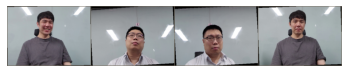

input shape: torch.Size([3, 250, 355]) / label shape: torch.Size([]) / label: 0
input shape: torch.Size([3, 250, 355]) / label shape: torch.Size([]) / label: 0
input shape: torch.Size([3, 250, 355]) / label shape: torch.Size([]) / label: 1
input shape: torch.Size([3, 250, 355]) / label shape: torch.Size([]) / label: 1


In [44]:
from datasets import Folder_Dataset
from utils import imshow_dataloader

folder_Dataset = Folder_Dataset(cfg['registered_data'])

dataloaders, dataset_sizes, idx_to_class = folder_Dataset.createDataLoaders()

# show a example picture 
image_size = imshow_dataloader(dataloaders["train"])

phase="train"
for i, (inputs, labels) in enumerate(dataloaders[phase]):
  if i > 3:
    break
  print(f'input shape: {inputs[0].shape} / label shape: {labels[0].shape} / label: {labels[0]}')
  

# Train model

In [45]:
from modules import Builder
import torch.nn as nn
import torch.optim as optim

builder = Builder(cfg['builder'])
builder.summary()
model = builder.getModel()

# declaration for learning and testing|
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

device is cuda:0
Loading model was just completed.
InceptionResnetV1(
  (conv2d_1a): BasicConv2d(
    (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU()
  )
  (conv2d_2a): BasicConv2d(
    (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU()
  )
  (conv2d_2b): BasicConv2d(
    (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU()
  )
  (maxpool_3a): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2d_3b): BasicConv2d(
    (conv): Conv2d(64, 80, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(80, eps=0.001, momentum=0.1, affine=True, track_running

In [46]:
from modules import runner
phases = ['train', 'val']

model, train_evaluation_matrix, val_evaluation_matrix = runner(cfg['runner'],
                                                                model,
                                                                phases,
                                                                criterion,
                                                                optimizer,
                                                                scheduler,
                                                                dataloaders,
                                                                dataset_sizes,
                                                                num_epochs=10)

Epoch 0/9
[phase]:train
train Loss: 0.6031 Acc: 0.8042 recall: 0.8031 Precision: 0.8484 avg_prob: 0.8344
[phase]:val
val Loss: 0.1497 Acc: 0.9333 recall: 0.8191 Precision: 0.8586 avg_prob: 0.9473
----------------------------------------------------------------------------------------------------
Epoch 1/9
[phase]:train


KeyboardInterrupt: 

30 4


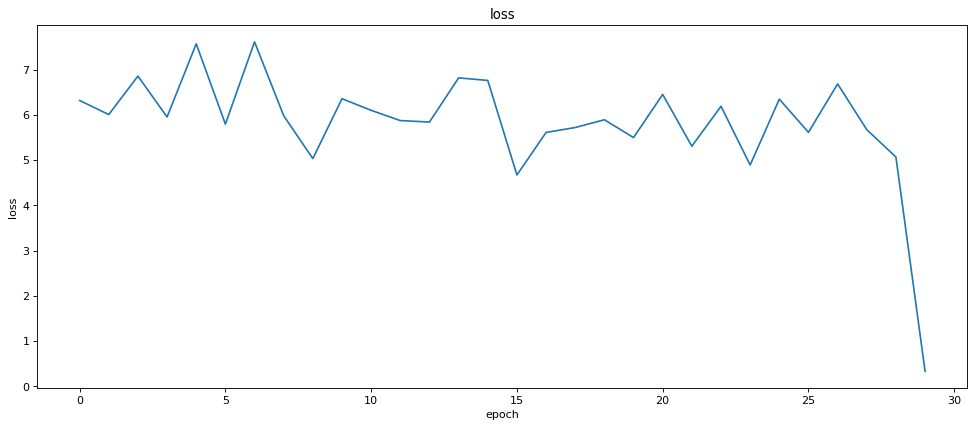

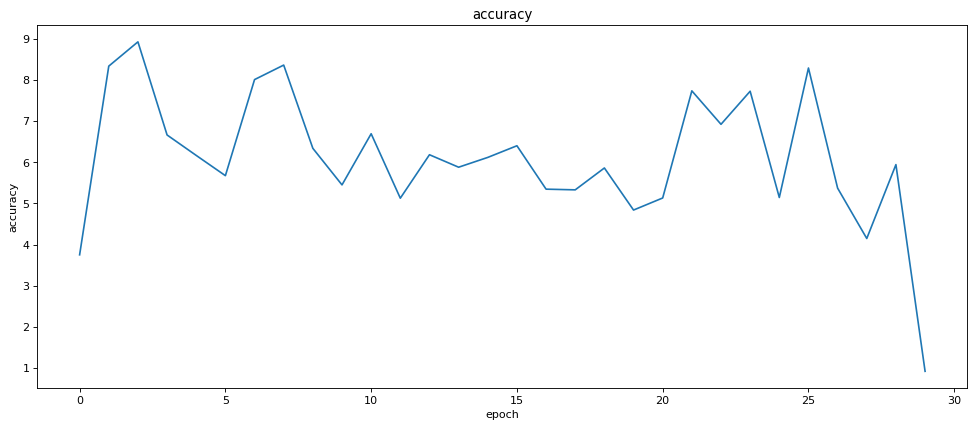

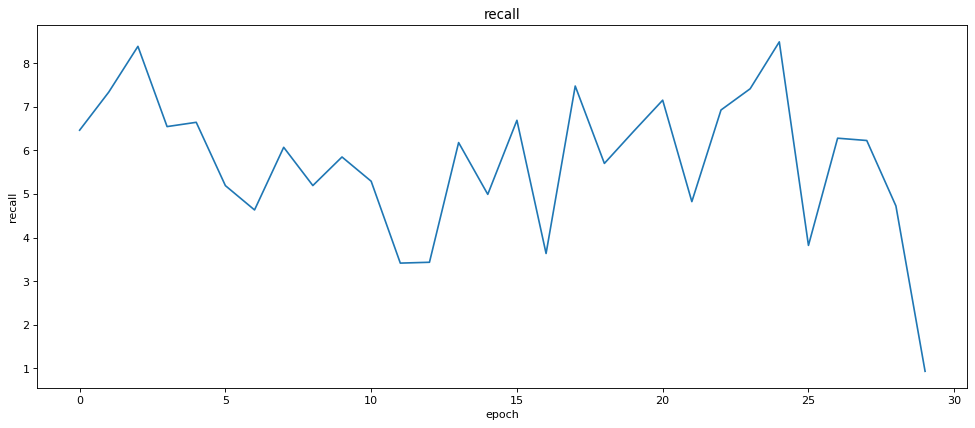

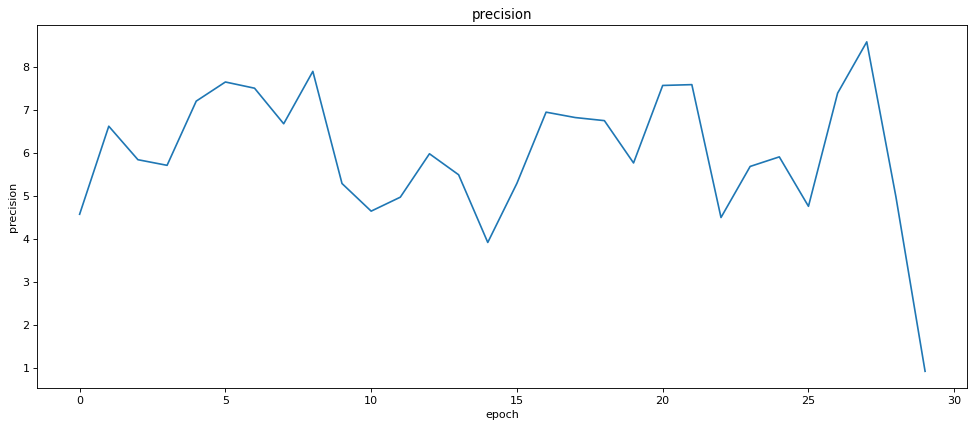

In [ ]:
import matplotlib.pyplot as plt
train_evaluation_numpy = train_evaluation_matrix.to('cpu').numpy()
val_evaluation_numpy = val_evaluation_matrix.to('cpu').numpy()

num_epochs, num_evaluations = train_evaluation_numpy.shape
print(num_epochs, num_evaluations)

title_list = ['loss', 'accuracy', 'recall', 'precision']
for col, title in zip(range(0, num_evaluations), title_list):
  plt.figure(figsize=(15, 6), dpi=80)
  plt.title(title)
  plt.ylabel(title)
  plt.xlabel('epoch')
  plt.plot(range(0, num_epochs), train_evaluation_numpy[:, col])
  plt.show()

In [ ]:
phases = ['test']
runner(model, phases, criterion, optimizer, scheduler, dataloaders, dataset_sizes, num_epochs=1)

Epoch 0/0
[phase]:test
test Loss: 0.0184 Acc: 1.0000 recall: 1.0000 Precision: 1.0000
----------------------------------------------------------------------------------------------------
Training complete in 0m 1s
Best val Acc: 0.000000
there is no return value becasue of test mode


## Save trained model

In [ ]:
import torch
cfg = cfgm.get_cfg()
path_for_saving_model = cfg['path_for_saving_model']

try: 
  torch.save(model.state_dict(), path_for_saving_model)
  print(f'successfully saved model in {path_for_saving_model}')
except:
  print(f'failed saving model in {path_for_saving_model}')

successfully saved model in ./data/face-extraction-model.pt


# After train

In [ ]:
folder_Dataset.setIsSplit(False)
dataloaders, dataset_sizes = folder_Dataset.createDataLoaders()

In [ ]:
phases = ['test']
prob = runner(model, phases, criterion, optimizer, scheduler, dataloaders, dataset_sizes, num_epochs=1)
print(prob)

Epoch 0/0
[phase]:test
test Loss: 0.0235 Acc: 1.0000 recall: 1.0000 Precision: 1.0000 avg_prob: 0.9823
----------------------------------------------------------------------------------------------------
Training complete in 0m 4s
Best val Acc: 0.000000
there is no return value becasue of test mode
tensor(0.9823)


In [ ]:
import numpy as np
threshold_list = np.arange(0, 1, 0.1)


for threshold in threshold_list:
    threshold = np.round(threshold, 2)
    
    print(threshold)
    prob = runner(model, phases, criterion, optimizer, scheduler, dataloaders, dataset_sizes, threshold=threshold, num_epochs=1)
    

0.0
0.1
0.2
0.3
0.4
0.5
0.6
0.7
0.8
0.9
